XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   32 / length of dimension 1                          NAXIS2  =                 4620 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                    8 / number of table fields                         TTYPE1  = 'flux    '                                                            TFORM1  = 'E       '                                                            TTYPE2  = 'loglam  '                                                            TFORM2  = 'E       '                                                            TTYPE3  = 'ivar    '                    

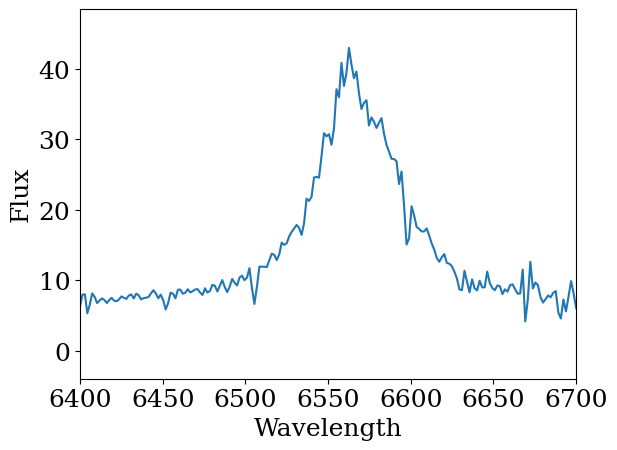

In [10]:
from astropy.io import fits
import matplotlib.pyplot as plt

hdul = fits.open('Main_Spectra_Files/spec-4216-55477-0224.fits')
data = hdul[1].data
hdr = hdul[1].header
flux = data['flux']
wl = 10**data['loglam']
z = 0.51782
wl = wl / (1 + z)

#print(data.columns)
err = data['ivar']
err = 1 / (err**0.5)

print(hdr)

plt.plot(wl, flux)
plt.xlim(6400, 6700)
#plt.ylim(-1, )
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.show()

In [11]:
%matplotlib inline
import os,sys
import matplotlib
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import sfdmap
import extinction
from astropy import units as u
import math
import latex

# pyqsofit
from scipy import interpolate

# for SDSS SQL queries
import mechanize
from io import BytesIO

import glob,timeit

#sys.path.append('/Users/runnojc1/Software/py/pyspeckit')
import pyspeckit
from pyspeckit.spectrum.models.inherited_gaussfitter import gaussian
from pyspeckit.specwarnings import PyspeckitWarning
from astropy.table import Table
import matplotlib as mpl


[   1    1    2 ... 4452 4453 4455]
4620
4620


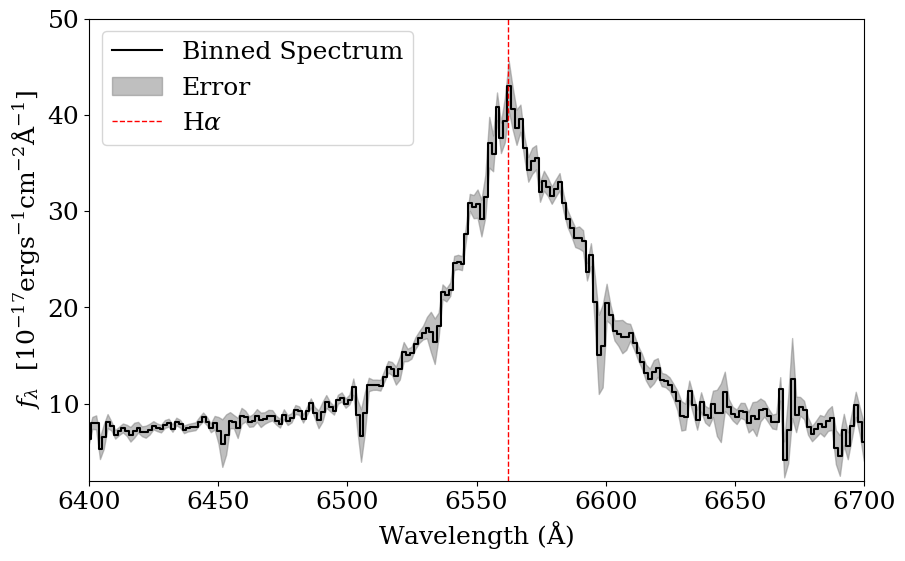

In [12]:
plt.rc('text', usetex=False)
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
    "mathtext.fontset": "dejavuserif",
    "mathtext.rm": "serif",
    "font.size": 18,
})


z = 0.51782

bin_width = 1  

bins = np.arange(min(wl), max(wl) + bin_width, bin_width)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

indices = np.digitize(wl, bins)

print(indices)

binned_wl = []
binned_flux = []
binned_flux_err = []

print(len(err))
print(len(flux))

for i in range(1, len(bins)):
    in_bin = indices == i
    if np.any(in_bin):
        binned_wl.append(np.mean(wl[in_bin]))
        binned_flux.append(np.mean(flux[in_bin]))
        binned_flux_err.append(np.mean(err[in_bin]))
    else:
        pass

binned_wl = np.array(binned_wl)
binned_flux = np.array(binned_flux)
binned_flux_err = np.array(binned_flux_err)

plt.figure(figsize=(10, 6))
plt.plot(binned_wl, binned_flux, label='Binned Spectrum', color="black", drawstyle='steps-mid')
plt.fill_between(binned_wl, binned_flux - binned_flux_err, binned_flux + binned_flux_err, color='gray', alpha=0.5, label='Error')
plt.axvline(x=6562, color='r', linestyle='--', linewidth=1, label=r"H$\alpha$")
plt.xlabel(r"Wavelength ($\rm \AA$)")
plt.ylabel(r"$f_{\lambda}$  $\rm [10^{-17} erg s^{-1} cm^{-2} \AA^{-1}]$")
plt.xlim(6400, 6700)
plt.ylim(2, 50)
plt.legend(loc="upper left")
plt.savefig("halpha.pdf")
plt.show()

In [13]:
mask = np.where((binned_wl > 6400)&(binned_wl < 6700))[0]

lam = binned_wl[mask]
flux_red = binned_flux[mask]
err  = binned_flux_err[mask]


err[np.where(err==np.inf)] = np.max(err[np.where(err!=np.inf)])

lam = np.nan_to_num(lam)
flux_red = np.nan_to_num(flux_red)
err = np.nan_to_num(err)

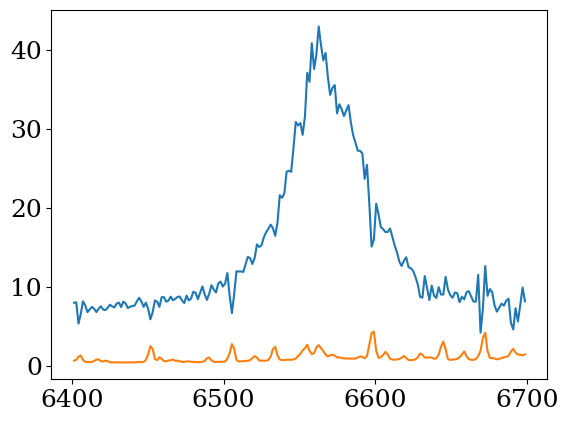

In [14]:
plt.plot(lam, flux_red)
plt.plot(lam, err)
plt.show()

In [15]:
# download spectrum from SDSS
path_dust = 'C:/Users/Radh/Downloads/sfddata-master/sfddata-master/'
ra = 0.29666
dec = -0.33654
z = 0.51782

In [16]:
# deredden the spectrum

lam = lam*(1+z)
m   = sfdmap.SFDMap(path_dust)
ebv = m.ebv(ra, dec)
Av  = 3.1*ebv
zero_flux  = np.where(flux_red == 0, True, False)
flux_red[zero_flux] = 1e-10
print(len(lam), len(flux_red), len(err))
flux = extinction.remove(extinction.fitzpatrick99(lam.astype('double'),Av, 3.1),flux_red)
err_unred  = err*flux/flux_red
flux[zero_flux] = 0
err_unred[zero_flux] = 0

lam = lam/(1+z)

198 198 198


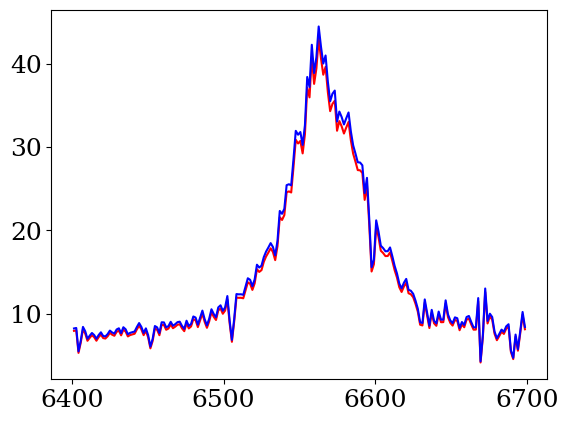

In [17]:
plt.plot(lam, flux_red, 'r')
plt.plot(lam, flux, 'b')
#plt.xlim(1, 1800)
#plt.ylim(-100, 400)
plt.show()

In [18]:
#FUNCTION TO FIT GAUSSIAN

def kms_to_ang(dv,w0):
    """
    Convert a width in km/s to A.
    """
    c = 2.99792458e5 # km/s
    dlam = (dv/c)*w0
    return dlam

In [19]:
def powerlaw(x, scale, power):
    """
    Defines a power law

    Returns
    -------
    scale * x**power
    """
    return scale*(x/1000.)**-power

In [20]:
def gaussian(xarr,amplitude,cent,fwhm,normalized=False,return_components=False,return_hyperfine_components=False):
    """
    Returns a 1-dimensional gaussian of form
    A*np.exp(-(x-dx)**2/(2*w**2))

    Area is sqrt(2*pi*sigma^2)*amplitude - i.e., this is NOT a normalized
    gaussian, unless normalized=True in which case A = Area
    
    Parameters
    ----------
    xarr : np.ndarray
        array of x values
    amplitude : float
        Amplitude of the Gaussian, i.e. its peak value, unless
        normalized=True then A is the area of the gaussian
    cent : float
        Center or "shift" of the gaussian same units as xarr
    fwhm : float
        Full width at half maximum of the Gaussian in km/s
    return_components : bool
        dummy variable; return_components does nothing but is required by all
        fitters
    return_hyperfine_components : bool
        dummy variable; does nothing but is required by all
        fitters
    normalized : bool
        Return a normalized Gaussian?
    """ 
    fwhm = kms_to_ang(fwhm,cent)
    if fwhm == 0:
        return np.nan
    elif fwhm < 0:
        warnings.warn("Negative width in Gaussian: {0}.".format(fwhm),
                      PyspeckitWarning)

    width = fwhm/np.sqrt(8*np.log(2))
    xarr = np.array(xarr) # make sure xarr is no longer a spectroscopic axis
    model = amplitude*np.exp(-(xarr-cent)**2/(2.0*width**2))
    if normalized:
        return model / (np.sqrt(2*np.pi) * width**2)
    else:
        return model

In [21]:
# load the templates
feii_template_path='fe_op_templates.npy'
stellar_template_path='PyQSOfit_MILES_templates.dat'
#balmer_cont_template_path='C:/Users/serat/Downloads/balmer_cont_templates.npy'
#balmer_highorder_template_path='C:/Users/serat/Downloads/balmer_highorder_templates.npy'

num_templates_feii=100
num_templates_host=8
#num_templates_balmer_cont=20
#num_templates_balmer_highorder=21

feii_templates=np.load(feii_template_path,allow_pickle=True)
stellar_templates=np.genfromtxt(stellar_template_path,skip_header=5)
#balmer_cont_templates=np.load(balmer_cont_template_path,allow_pickle=True)
#balmer_highorder_templates=np.load(balmer_highorder_template_path,allow_pickle=True)

In [22]:
def template_fitter(wave,templates,scale_factor,index,shift):
    '''
    given a series of templates (like stellar models by age or Fe II templates by convolution width),
    returns a spectrum interpolated between template spectra and scaled.
    Spectrum is also interpolated onto the wavelength vector of the observed data.
    
    params:
        wave - wavelength vector of observed data
        templates - 2D numpy array of shape (numpoints,num_templates+1), where 1st column is wavelength, subsequent columns are templates
        index - selected index within templates [0-num_templates]. Float, will interpolate between templates when index!=int
        scale_factor - multiplicative scale factor for spectrum
    '''
    num_templates=templates.shape[1]-1
    numpoints=templates.shape[0]
    
    if shift>=0:
        wave_temp=templates[:,0]*(1+shift)
    else:
        wave_temp=templates[:,0]/(1+shift)
    flux_temp=templates[:,1:]
    
    # Perform interpolation between templates
    if index==num_templates-1:
        spectrum=templates[:,-1]
    else:
        lower_idx=int(math.floor(index)+1) #+1 because 0th index is wavelength column
        if lower_idx >= templates.shape[1]:
            lower_idx = templates.shape[1] - 1
        if lower_idx >= templates.shape[1]:
            lower_idx = templates.shape[1] - 2
        lower_spectrum=templates[:,lower_idx] # this means lower in index, not necessarily in flux
        
        upper_idx=lower_idx+1
        #print(upper_idx, templates.shape)
        #print(len(templates[:,]))
        if upper_idx >= templates.shape[1]:
            upper_idx = templates.shape[1] - 1
        if upper_idx >= templates.shape[1]:
            upper_idx = templates.shape[1] - 2
        upper_spectrum=templates[:,upper_idx]
        
        weight=(index+1)-lower_idx #1=choose upper spectrum value, 0=choose lower spectrum value, 0.5=choose midpoint
        
        distances=upper_spectrum-lower_spectrum # array of distances between selected spectra
        
        spectrum=lower_spectrum+(weight*distances)
        
    # Perform scaling
    scaled_spectrum=spectrum*scale_factor
    
    # interpolate spectrum onto wavelength vector of data
    final_spectrum=np.interp(wave,wave_temp,scaled_spectrum)

    return final_spectrum

In [23]:
# Need to change for Optical

def visible_agn_spectrum(wave_to_fit,pl_s,pl_e,fe_s,fe_index,fe_shift,sb_s,sb_index,sb_shift,\
                    h1_f,h1_cent,h1_fwhm,\
                    h2_f,h2_cent,h2_fwhm,\
                    h3_f,h3_cent,h3_fwhm,\
                    #si1_f,si1_cent,si1_fwhm,\
                    #civ1_f,civ1_cent,civ1_fwhm,\
                    #civ2_f,civ2_cent,civ2_fwhm,\
                         return_components=False,return_hyperfine_components=False):
    """
    Calculates a full optical AGN spectral model.
    """
    
    #x = wave_to_fit.to_value()
    x = np.array(wave_to_fit)
    y = np.zeros_like(x)
    
    # powerlaw
    pl = powerlaw(x,pl_s,pl_e)

    # optical Fe II template
    feii = template_fitter(x,feii_templates,fe_s,fe_index,fe_shift)
    
    # MILES stellar template
    sb = template_fitter(x,stellar_templates,sb_s,sb_index,sb_shift)
    
    
    # H beta template
    h1 = gaussian(x,h1_f,h1_cent,h1_fwhm,normalized=False)
    h2 = gaussian(x,h2_f,h2_cent,h2_fwhm,normalized=False)
    h3 = gaussian(x,h3_f,h3_cent,h3_fwhm,normalized=False)
    
    
   
    y = pl + feii + sb + h1 + h2 + h3 
    
    
    if return_components:
        y = {'model':y,\
             'pl':pl,\
             'feii':feii,\
             'sb':sb,\
             'h1':h1,\
             'h2':h2,\
             'h3':h3}  
    
    return y

In [24]:
def pl_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(powerlaw, 2,
            parnames=['scale','power'], 
            parlimited=[(False,False),(False,False)], 
            parlimits=[(0,0),(0,0)], 
            shortvarnames=('S','P')
            )
    myclass.__name__ = "pl"
    
    return myclass

In [25]:
# optical Fe II template
feii = template_fitter(wl,feii_templates,5.998670502,19.99812006,-1)

# MILES stellar template
sb = template_fitter(wl,stellar_templates,1.999936763,5.00033816,-0.0001580000002)


#   FE_S0 = 5.998670502  
   #FE_INDEX0 = 19.99812006  
  # FE_SHIFT0 = -1  
   #SB_S0 = 1.999936763  
  # SB_INDEX0 = 5.00033816  
  # SB_SHIFT0 = -0.0001580000002  

In [26]:
# Need to change 


def visible_agn_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(visible_agn_spectrum, 17,
            parnames=['pl_s','pl_e','fe_s','fe_index','fe_shift','sb_s','sb_index','sb_shift',\
                      'h1_f', 'h1_cent', 'h1_fwhm',\
                      'h2_f', 'h2_cent', 'h2_fwhm',\
                      'h3_f', 'h3_cent', 'h3_fwhm'], 
            parlimited=[(False,False),(False,False),\
                        (False,False),(True,True),(True,True),\
                        (False,False),(True,True),(True,True),\
                        (False,False), (False,False), (False,False),\
                        (False,False), (False,False), (False,False),\
                        (False,False), (False,False), (False,False)], 
            parlimits=[(0,0),(0,0),\
                       (0,0),(0,100),(-1,1),\
                       (0,0),(0,8),(-1,1),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0)]
            )
    myclass.__name__ = "visibleagn"
    
    return myclass

In [27]:
# SETUP 
##############################################################
##############################################################
fontfamily = 'Times New Roman'
matplotlib.rcParams['font.family'] = fontfamily
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rc('text', usetex=False)
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
plt.rc('xtick.major',pad=2)
plt.rc('ytick.major',pad=2)
plt.rc('xtick.minor',pad=2)
plt.rc('ytick.minor',pad=2)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('font',size=24,weight='bold')
plt.rcParams['axes.labelweight'] = 'bold'

blood_orange = [204/255,17/255,0/255]
indian_red = [176/255,23/255,31/255]
indian_red = [200/255,23/255,31/255]
green = [0/255,205/255,0/255]
dark_orange = [255/255,127/255,0/255]
goldenrod = [255/255,193/255,37/255]
midnight_blue = [25/255,25/255,112/255]
transparent_blue = [138/255,181/255,220/255]
gray = [130/255,130/255,130/255]
dark_gray = [50/255,50/255,50/255]
salmon = [250/255,128/255,114/255]
royal_blue = [0/255,0/255,200/255]
turquoise  = [0/255,204/255,204/255]
cyan  = [0/255,255/255,255/255]
pink = [255/255,0/255,127/255]
med_pink = [191/255, 0/255, 96/255]
dark_pink = [128/255, 0/255, 64/255]

In [28]:
def plot_visible_agn_fit(wave,flux,model,wavemin,wavemax,ymin,ymax,xlabel,ylabel,plotfile,HARDCOPY=False,SHOW=True):
    #ly1 = model['ly1']+model['ly2']
    #o1 = model['o1']+model['o2']+model['o3']+model['o4']+model['o5']
    h1 = model['h1']
    h2 = model['h2']
    narrow_1 = h1 + h2
    h_broad = model['h3']
    feii = model['feii']
    sb = model['sb']
    
    
    fig = plt.figure(figsize=(10, 6))
    ax  = plt.axes()
    ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    ax.plot(wave,model['model'],color=indian_red,lw=2)
    ax.plot(wave,model['pl'],color=royal_blue)
    ax.plot(wave,feii,color=dark_gray)
    ax.plot(wave,sb,color=dark_gray)
    #ax.plot(wave,narrow_1,color=turquoise)
    ax.plot(wave,h1,color=turquoise)
    ax.plot(wave,h2,color=turquoise)
    #ax.plot(wave,narrow_2,color=turquoise)
    #ax.plot(wave,narrow_3,color=turquoise)
    ax.plot(wave,h_broad,color=salmon)
    #ax.plot(wave,o1,color=turquoise)
    #ax.plot(wave,o2,color=salmon)
    #ax.plot(wave,si1,color=turquoise)
    #ax.plot(wave,civ_broad,color=turquoise)
    #ax.plot(wave,civ_narrow,color=salmon)
    ax.set_xlim(wavemin,wavemax)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.tight_layout()
    if HARDCOPY: fig.savefig(plotfile+'_fullfit.pdf', format='pdf')
    if SHOW: plt.show()
    plt.close(fig)

In [29]:
# set up the relevant emission lines
z = 0.51782

h1 = 6562.819 #S-II
h2 = 6562.819 #H-alpha
h3 = 6562.819 #H-alpha broad


h1_off = h2/h1

print(h1, h3)


c = 2.99e5 # km/s

6562.819 6562.819


In [30]:
# Need to change
guesses = [5, 0,\
           5.,20,0.,\
           2.,5,0.,\
           30, h1, 200,\
           10, h2, 200,\
           13.6, h3, 4000]
           
tied = ['','',\
        '','','',\
        '','','',\
        '','','',\
        'p[8]/3','','p[10]',\
        '','','']

fixed = [0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0]

lmin = [False,False,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True]

lmax = [False,False,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True,
        True,True,True]

minp = [0,0,\
        0,0,-0.05,\
        0,0,-0.05,\
        0,6400,50,\
        0,6400,50,\
        0,6400,1000]

maxp = [0,0,\
        1e6,99,0.05,\
        1e6,7,0.05,\
        1e6,6700,1000,\
        1e6,6700,1000,\
        1e6,6700,7000]

step = [0.5, 0.05,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5]

In [31]:
# this actually does the fit after resetting the spectrum

spec = pyspeckit.Spectrum(data=flux, xarr=lam,error=err)
spec.unit = 'erg s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$'
spec.xarr.set_unit = u.angstrom #'$\\AA$'
spec.xarr.xtype='angstrom'
spec.Registry.add_fitter('visibleagn',visible_agn_fitter(),17)
spec.specfit.selectregion(xmin=6400,xmax=6700)
spec.specfit(fittype='visibleagn',vheight=False,guesses=guesses,tied=tied,fixed=fixed,limitedmin=lmin,limitedmax=lmax,minpars=minp,maxpars=maxp,parsteps=step,maxiter=250,baseline=False,subtract_baseline=False,quiet=False)

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,198 [pyspeckit.spectrum.interactive]
Iter       1    CHI-SQUARE =  4630.117129  DOF =  183
   PL_S0 = 5  
   PL_E0 = 0  
   FE_S0 = 5  
   FE_INDEX0 = 20  
   FE_SHIFT0 = 0  
   SB_S0 = 2  
   SB_INDEX0 = 5  
   SB_SHIFT0 = 0  
   H1_F0 = 30  
   H1_CENT0 = 6562.819  
   H1_FWHM0 = 200  
   H2_F0 = 10  
   H2_CENT0 = 6562.819  
   H2_FWHM0 = 200  
   H3_F0 = 13.6  
   H3_CENT0 = 6562.819  
   H3_FWHM0 = 4000  
Iter       2    CHI-SQUARE =  3975.141088  DOF =  183
   PL_S0 = 5.216395235  
   PL_E0 = -0.1059005815  
   FE_S0 = 5.761749902  
   FE_INDEX0 = 30.80515234  
   FE_SHIFT0 = 0  
   SB_S0 = 1.179487039  
   SB_INDEX0 = 7  
   SB_SHIFT0 = 0  
   H1_F0 = 28.33999526  
   H1_CENT0 = 6562.822367  
   H1_FWHM0 = 201.8080181  
   H2_F0 = 9.446665087  
   H2_CENT0 = 6562.819  
   H2_FWHM0 = 201.8080181  
   H3_F0 = 14.11610806  
   H3_CENT0 = 6563.274152  
   H3_FWHM0 = 3935.224807  
Iter       3    CHI-SQUARE =  3135.472811  D

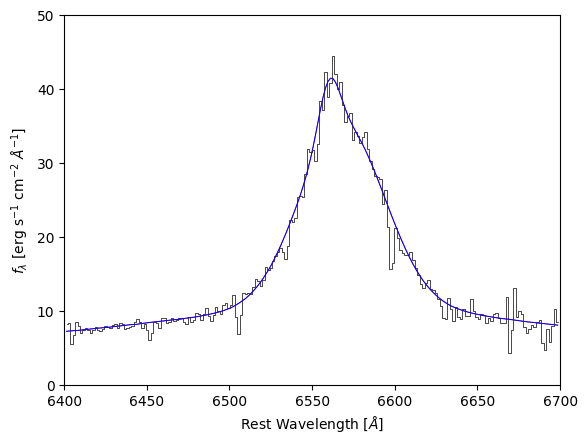

In [32]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
spec.plotter(xmin=6400,xmax=6700,ymin=0,ymax=50,xlabel='Rest Wavelength [$\AA$]',ylabel="$f_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
spec.specfit.plot_fit(annotate=False)
spec.specfit.plot_components()
plt.show()

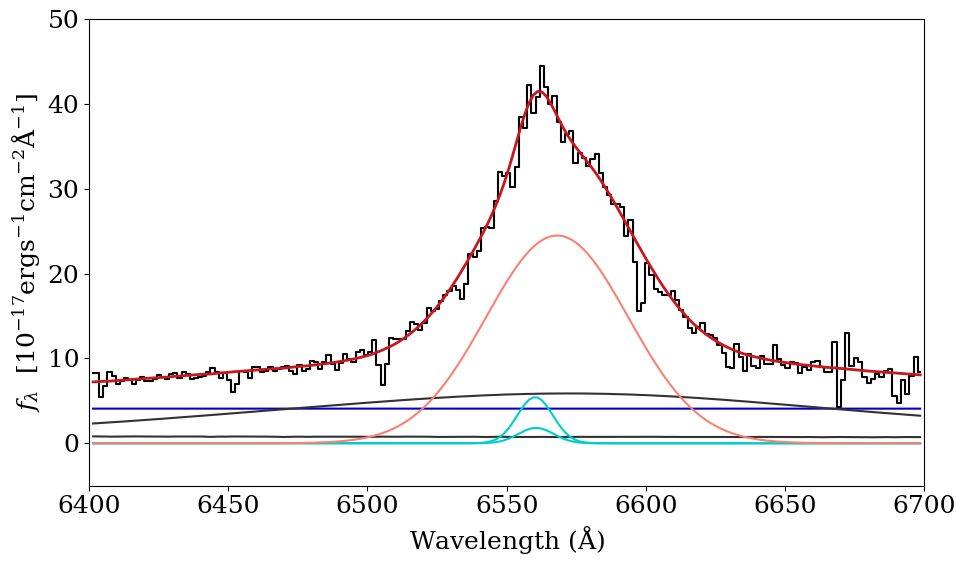

In [33]:
best_model = visible_agn_spectrum(lam,*spec.specfit.parinfo.values,return_components=True)

wavemin = 6400.
wavemax = 6700.
ymin = 0.
ymax = 50.
wave = lam
flux = flux
model = best_model
xlabel = 'Wavelength $[\AA]$'
ylabel = '$f_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]'
plotfile = 'visible1'
HARDCOPY = False
SHOW = True
plt.rc('text', usetex=False)
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
    "mathtext.fontset": "dejavuserif",
    "mathtext.rm": "serif",
    "font.size": 18,
})

plot_visible_agn_fit(lam,flux,best_model,6400,6700,-5,50,r"Wavelength ($\rm \AA$)",\
                     r"$f_{\lambda}$  $\rm [10^{-17} erg s^{-1} cm^{-2} \AA^{-1}]$",\
                     plotfile,HARDCOPY=True,SHOW=True)

In [34]:
print(spec.specfit.parinfo)

Param #0        PL_S0 =      4.25797 +/-         48.6944 
Param #1        PL_E0 =    0.0221673 +/-         5.59975 
Param #2        FE_S0 =      29.0207 +/-         6.42925   Range: [0,1e+06]
Param #3    FE_INDEX0 =      92.5829 +/-         63.7655   Range:    [0,99]
Param #4    FE_SHIFT0 =         0.05 +/-               0   Range:[-0.05,0.05]
Param #5        SB_S0 =     0.564577 +/-         4.18643   Range: [0,1e+06]
Param #6    SB_INDEX0 =     0.998101 +/-         34.5651   Range:     [0,7]
Param #7    SB_SHIFT0 =         0.05 +/-               0   Range:[-0.05,0.05]
Param #8        H1_F0 =      5.44577 +/-         17.9018   Range: [0,1e+06]
Param #9     H1_CENT0 =      6560.23 +/-         519.428   Range:[6400,6700]
Param #10     H1_FWHM0 =      683.048 +/-         2254.52   Range: [50,1000]
Param #11        H2_F0 =      1.81526 +/-               0   Range: [0,1e+06] Tied: p[8]/3
Param #12     H2_CENT0 =      6560.58 +/-         1560.13   Range:[6400,6700]
Param #13     H2_FWHM0 =  